In [9]:
import numpy as np
import xarray as xr
import time 
import os
from netCDF4 import Dataset
from pyproj import CRS
import rasterio
import rioxarray
from rasterio.enums import Resampling
from sklearn.preprocessing import StandardScaler

In [6]:
filename_biostates_2019 = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/BioStates_2019.nc'
biostates_2019 = xr.open_dataset(filename_biostates_2019)

In [10]:
filename_biostates_2022 = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/BioStates_2022.nc'
biostates_2022 = xr.open_dataset(filename_biostates_2022)

In [6]:
print(list(biostates_2022.variables))

['time', 'grid_mapping', 'LayerDepths', 'xc', 'yc', 'zc', 'depth', 'DXxDYy', 'nitrate', 'silicate', 'ammonium', 'diatoms', 'flagellates', 'ciliates', 'HNANO', 'bacteria', 'calanus_finmarchicus', 'calanus_glacialis', 'detritus_slow', 'detritus_fast', 'DOC', 'cDOM', 'silicate_detritus', 'sediment_Si', 'sediment_N']


In [9]:
diatoms_2019 = biostates_2019['diatoms']
valid_mask = ~diatoms_2019.isnull()  
top_layer_idx = valid_mask.argmax(dim="zc")
no_valid_data_mask = valid_mask.sum(dim="zc") == 0
diatoms_top_layer_2019 = diatoms_2019.isel(zc=top_layer_idx)
diatoms_top_layer_2019 = diatoms_top_layer_2019.where(~no_valid_data_mask, np.nan)

In [11]:
diatoms_top_layer_2019.to_netcdf('/cluster/home/maikents/surface_chlorophyll/diatoms_2019.nc')

In [14]:
diatoms_2022 = biostates_2022['diatoms']
valid_mask = ~diatoms_2022.isnull()  
top_layer_idx = valid_mask.argmax(dim="zc")
no_valid_data_mask = valid_mask.sum(dim="zc") == 0
diatoms_top_layer_2022 = diatoms_2022.isel(zc=top_layer_idx)
diatoms_top_layer_2022 = diatoms_top_layer_2022.where(~no_valid_data_mask, np.nan)

In [15]:
diatoms_top_layer_2022.to_netcdf('/cluster/home/maikents/surface_chlorophyll/diatoms_2022.nc')

In [7]:
flagellates_2019 = biostates_2019['flagellates']
valid_mask = ~flagellates_2019.isnull()  
top_layer_idx = valid_mask.argmax(dim="zc")
no_valid_data_mask = valid_mask.sum(dim="zc") == 0
flagellates_top_layer_2019 = flagellates_2019.isel(zc=top_layer_idx)
flagellates_top_layer_2019 = flagellates_top_layer_2019.where(~no_valid_data_mask, np.nan)

In [8]:
flagellates_top_layer_2019.to_netcdf('/cluster/home/maikents/surface_chlorophyll/flagellates_2019.nc')

In [11]:
flagellates_2022 = biostates_2022['flagellates']
valid_mask = ~flagellates_2022.isnull()  
top_layer_idx = valid_mask.argmax(dim="zc")
no_valid_data_mask = valid_mask.sum(dim="zc") == 0
flagellates_top_layer_2022 = flagellates_2022.isel(zc=top_layer_idx)
flagellates_top_layer_2022 = flagellates_top_layer_2022.where(~no_valid_data_mask, np.nan)

In [12]:
flagellates_top_layer_2022.to_netcdf('/cluster/home/maikents/surface_chlorophyll/flagellates_2022.nc')

In [13]:
diatoms_top_layer_2022 = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/diatoms_2022.nc')
diatoms_top_layer_2019 = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/diatoms_2019.nc')


In [16]:
diatoms_top_layer_2022 = diatoms_top_layer_2022.isel(time=slice(0, 365))

In [18]:
diatoms_top_layer = xr.concat([diatoms_top_layer_2019, diatoms_top_layer_2022], dim="time")


diatoms_top_layer.to_netcdf('/cluster/home/maikents/surface_chlorophyll/diatoms_2019_2022.nc')

In [19]:
flagellates_top_layer_2022 = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/flagellates_2022.nc')
flagellates_top_layer_2019 = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/flagellates_2019.nc')


In [20]:
flagellates_top_layer_2022 = flagellates_top_layer_2022.isel(time=slice(0, 365))

In [21]:
flagellates_top_layer = xr.concat([flagellates_top_layer_2019, flagellates_top_layer_2022], dim="time")


flagellates_top_layer.to_netcdf('/cluster/home/maikents/surface_chlorophyll/flagellates_2019_2022.nc')

In [34]:
diatoms = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/diatoms_2019_2022.nc')
flagellates = xr.open_dataset('/cluster/home/maikents/surface_chlorophyll/flagellates_2019_2022.nc')

In [35]:
diatoms_top_layer = diatoms['diatoms']
flagellates_top_layer = flagellates['flagellates']

print(diatoms_top_layer.shape)
print(flagellates_top_layer.shape)

(730, 555, 950)
(730, 555, 950)


In [36]:
mmolN2gC = 7.6 * 12 * 0.001  
Chl_C_D = 0.035 
Chl_C_F = 0.013  

#surface chlorophyll
chl_mg_2019_2022 = 1e3 * mmolN2gC * (Chl_C_D * diatoms_top_layer + Chl_C_F * flagellates_top_layer)

chl_mg_2019_2022_da = xr.DataArray(
    chl_mg_2019_2022,
    coords={"time": diatoms["time"], "yc": diatoms["yc"], "xc": diatoms["xc"]},
    dims=["time", "yc", "xc"],
)

print(chl_mg_2019_2022_da)


<xarray.DataArray (time: 730, yc: 555, xc: 950)> Size: 2GB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.18766582, 0.18766582, 0.18766582, ..., 0.19163187,
         0.19163187, 0.19163187],
        [0.18766582, 0.18766582, 0.18766582, ..., 0.19163187,
         0.19163187, 0.19163187],
        [0.18766582, 0.18766582, 0.18766582, ..., 0.19163187,
         0.19163187, 0.19163187]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.2080528 , 0.2080528 , 0.2080528 , ..., 0.174932

In [37]:
chl_ds = xr.Dataset(
    {
        "chl_mg": chl_mg_2019_2022_da
    }
)
print(chl_ds)

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 730, yc: 555, xc: 950)
Coordinates:
  * time     (time) int64 6kB 0 1 2 3 4 5 6 7 ... 723 724 725 726 727 728 729
  * yc       (yc) float32 2kB 800.0 1.6e+03 2.4e+03 ... 4.432e+05 4.44e+05
  * xc       (xc) float32 4kB 800.0 1.6e+03 2.4e+03 ... 7.592e+05 7.6e+05
Data variables:
    chl_mg   (time, yc, xc) float32 2GB nan nan nan nan ... 0.1749 0.1749 0.1749


In [38]:
chl_ds.to_netcdf('/cluster/home/maikents/surface_chlorophyll/surface_chlorophyll_2019_2022')

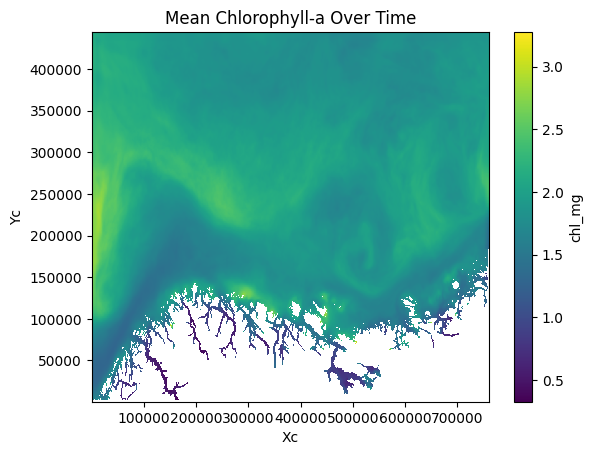

In [42]:
import matplotlib.pyplot as plt

chl_mean = chl_ds['chl_mg'].mean(dim='time')

chl_mean.plot()

plt.title('Mean Chlorophyll-a Over Time')
plt.xlabel('Xc')  
plt.ylabel('Yc')  s
plt.show()


In [43]:
#Create min, mean and max features across time

data_var = chl_ds['chl_mg']
time_avg_top_layer = data_var.mean(dim="time", skipna=True)
time_percentiles = data_var.quantile([0.1, 0.9], dim="time", skipna=True)

stats_array = xr.concat(
    [time_avg_top_layer, time_percentiles.sel(quantile=0.1).drop_vars("quantile"), 
     time_percentiles.sel(quantile=0.9).drop_vars("quantile")],
    dim="stat"
).rename(f"chlor_a_features")
stats_array = stats_array.assign_coords(stat=["mean", "10th_percentile", "90th_percentile"])

stats_array.to_netcdf('/cluster/home/maikents/surface_chlorophyll/surface_chlorophyll_2019_2022_features', mode='w')

/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


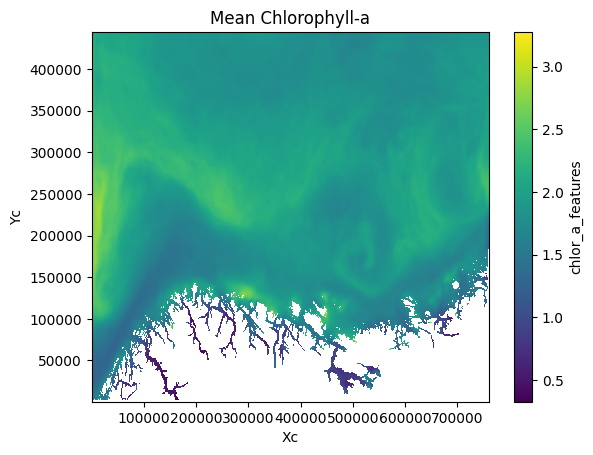

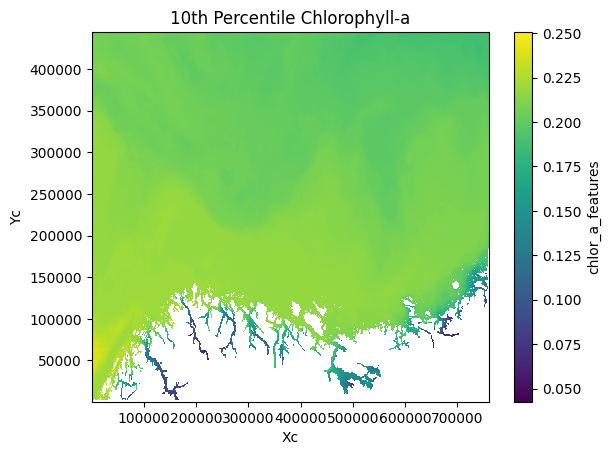

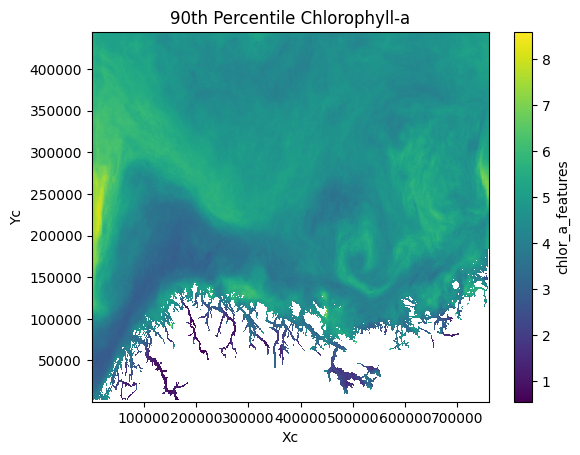

In [50]:
import matplotlib.pyplot as plt


stats_array.isel(stat=0).plot()
plt.title('Mean Chlorophyll-a')
plt.xlabel('Xc') 
plt.ylabel('Yc') 
plt.show()

stats_array.isel(stat=1).plot()
plt.title('10th Percentile Chlorophyll-a')
plt.xlabel('Xc') 
plt.ylabel('Yc')   
plt.show()

stats_array.isel(stat=2).plot()
plt.title('90th Percentile Chlorophyll-a')
plt.xlabel('Xc')  
plt.ylabel('Yc')  
plt.show()


In [ ]:
#Transform to emod!